## Features of paralogs influencing HD likelihood

In [7]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
import analysis_utils as au
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils
%aimport analysis_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_annot_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
file_gene_HDs = get_local_data_path(['processed'], 'all_gene_HDs.csv')
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)
file_unique_pairs = get_local_data_path(['processed', 'ensembl_93'], 'unique_pairs.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load annotated genes

In [3]:
genes = pd.read_csv(file_annot_genes)
passenger_genes = genes[~genes.TSG & ~genes.within_driver & ~genes.outside_bounds & ~genes.OG]
print('N genes:', genes.shape[0])
print('N TSG:', sum(genes.TSG))
print('N passenger genes:', passenger_genes.shape[0])
print('Paralogs: %d = %.2f%%' % (sum(passenger_genes.paralog), sum(passenger_genes.paralog)/passenger_genes.shape[0]*100))
display(genes[:1])

N genes: 17572
N TSG: 411
N passenger genes: 16898
Paralogs: 10588 = 62.66%


,symbol,entrez_id,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,n_paralogs,...,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG,within_driver,outside_bounds
0,A1BG,1,ENSG00000121410,19,58858387,58864802,CCDS12976,6415,58861594.5,NaN,...,False,never,False,False,False,False,False,False,False,False


### HDs per gene (across both cohorts)

In [4]:
all_gene_hds = pd.read_csv(file_gene_HDs)
passenger_hds = all_gene_hds[all_gene_hds.symbol.isin(passenger_genes.symbol)].reset_index(drop=True)

### Compute paralog features

In [4]:
def get_paralog_dels(passenger_hds):
    dels = passenger_hds[passenger_hds.paralog].reset_index(drop=True)
    dels['big_family'] = dels.n_paralogs>3
    return dels

paralog_hds = get_paralog_dels(passenger_hds)

In [19]:
def draw_feature_box_plot(paralog_hds, ax, feature, label='', title='', bins=['0','1+','3+'], fraction=0.05):
    df = pd.concat([au.compute_bin(paralog_hds, b, 'n_del').assign(del_bin=b) for b in bins])
    mwu1 = stats.mannwhitneyu(df[df.del_bin=='1+'][feature], df[df.del_bin=='0'][feature], alternative='two-sided')[1]
    mwu2 = stats.mannwhitneyu(df[df.del_bin=='3+'][feature], df[df.del_bin=='0'][feature], alternative='two-sided')[1]
    print('%.3e, %.3e' % (mwu1, mwu2))
    if feature=='n_paralogs':
        df[feature] = df[feature].clip(upper=25)
    ypos = df[feature].max(); ydiff = (df[feature].max()-df[feature].min())*fraction
    gp.draw_signif_MW(0, 1, ypos+ydiff, mwu1, ax, yoffset=ydiff, star=True)
    gp.draw_signif_MW(0, 2, ypos+ydiff*3.5, mwu2, ax, yoffset=ydiff, star=True)
    sns.boxplot(data=df, x='del_bin', y=feature, **gp.get_boxplot_props(), showmeans=False,
                ax=ax, palette=sns.color_palette('Blues',4))
    ax.set_xlabel('Samples with\ngene HD'); ax.set_ylabel(label);

In [121]:
def draw_feature_bar_plot(paralog_hds, feature, ylabel, ax, y1, y2, yoffset=4):
    df = pd.concat([au.compute_bin(paralog_hds, b, 'n_del').assign(hd_bin=b) for b in ['0','1+','3+']])
    # 0 vs. 1+
    OR1,p1 = stats.fisher_exact(pd.crosstab(paralog_hds[feature], paralog_hds.n_del>0), alternative='two-sided')
    print(OR1,p1)
    # 0 vs. 3+
    OR2,p2 = stats.fisher_exact(pd.crosstab(df[df.hd_bin.isin(['0','3+'])][feature], 
                                            df[df.hd_bin.isin(['0','3+'])].n_del>2), alternative='two-sided')
    print(OR2,p2)
    
    tab = df.groupby('hd_bin')[feature].apply(lambda x: sum(x))/df.groupby('hd_bin').size()*100
    tab.plot.bar(ax=ax, color=sns.color_palette('Blues',4), width=0.84, rot=0)
    
    ax.axhline(sum(paralog_hds[feature])/paralog_hds.shape[0]*100, color='k', linestyle='--')
    gp.set_axis_props(ax, ylabel=ylabel, xlabel='Samples with\ngene HD')
    gp.draw_signif_FET(0,1,y1,y1, OR1, p1, ax, yoffset=yoffset, color='#666', alpha='')
    gp.draw_signif_FET(0,2,y2,y2, OR2, p2, ax, yoffset=yoffset, color='#666', alpha='')

### Family size: big (4+ paralogs) vs. small family

1.2473082307407255 4.542521042606013e-08
1.4150739342457135 6.133846899460498e-08


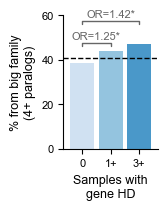

In [122]:
f, ax = plt.subplots(1, 1, figsize=(1.75,2.17), sharey=True)
draw_feature_bar_plot(paralog_hds, 'big_family', '% from big family\n(4+ paralogs)', ax, 45, 55)
ax.set_ylim([0,60]); plt.tight_layout()
plt.savefig('../figures/npar_bar.png', bbox_inches='tight', dpi=500)

### Sequence identity

2.425e-06, 2.676e-09


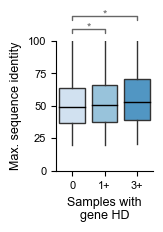

In [123]:
f, ax = plt.subplots(1, 1, figsize=(1.7,2.5), sharey=True)
draw_feature_box_plot(paralog_hds, ax, 'max_seq_id', label='Max. sequence identity')
ax.set_ylim([0,100]); ax.set_yticks([0,25,50,75,100])
plt.tight_layout()
plt.savefig('../figures/seqid_box.png', bbox_inches='tight', dpi=500)

In [124]:
print('Mean seq id 0 HDs: %.1f%%' % paralog_hds[paralog_hds.n_del==0].max_seq_id.mean())
print('Mean seq id 1+ HDs: %.1f%%' % paralog_hds[paralog_hds.n_del>=1].max_seq_id.mean())
print('Mean seq id 3+ HDs: %.1f%%' % paralog_hds[paralog_hds.n_del>=3].max_seq_id.mean())

Mean seq id 0 HDs: 51.7%
Mean seq id 1+ HDs: 53.7%
Mean seq id 3+ HDs: 56.4%


### Duplication mode: WGD vs. SSD

0.8691083507269433 0.0005002241127404752
0.7871318473332335 0.0001834090468894712


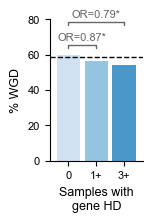

In [126]:
f, ax = plt.subplots(1, 1, figsize=(1.6,2.3), sharey=True)
draw_feature_bar_plot(paralog_hds, 'WGD', '% WGD', ax, 62, 75, yoffset=6)
ax.set_ylim([0,80]); plt.tight_layout()
plt.savefig('../figures/wgd_bar.png', bbox_inches='tight', dpi=500)

### Paralog pair deletions

In [15]:
tcga_hd_map = util.deserialize_map(folder_hd_maps('tcga_hd_map.csv'))

In [16]:
tcga_hds = util.count_dels_per_gene(tcga_hd_map, passenger_genes)

In [17]:
sample_gene_map = tcga_hd_map[['patient','chr','startpos','endpos','del_len','genes']].explode('genes')\
                          .rename(columns={'genes':'entrez_id'})
sample_gene_map = sample_gene_map.groupby('entrez_id').agg({'patient':list}).reset_index()
sample_gene_map[:1]

,entrez_id,patient
0,2,"[TCGA-AX-A2H4, TCGA-EE-A29V]"


#### Add deletion frequency for each gene, filtering to where both paralogs are passenger genes

In [45]:
all_paralog_pairs = pd.read_csv(file_unique_pairs)

In [46]:
paralog_pairs = pd.merge(all_paralog_pairs, tcga_hds[['symbol','n_del']].rename(columns={'symbol':'A1','n_del':'A1_del'}))
paralog_pairs = pd.merge(paralog_pairs, tcga_hds[['symbol','n_del']].rename(columns={'symbol':'A2','n_del':'A2_del'}))
paralog_pairs = paralog_pairs.astype({'A1_del':int,'A2_del':int})
print('N paralog pairs where both are passenger genes:', paralog_pairs.shape[0],'/',all_paralog_pairs.pair.nunique())
paralog_pairs[:1]

N paralog pairs where both are passenger genes: 22163 / 28568


,pair,min_seq_id,max_seq_id,WGD,same_chr,family_size,closest,A1,A2,A1_entrez,A1_chr,A2_entrez,A2_chr,A1_del,A2_del
0,DND1_RBM46,21.2008,32.0113,True,False,6,False,DND1,RBM46,373863,5,166863,4,0,1


#### Identify samples in which both genes are deleted

In [47]:
# Identify samples in which each genes is deleted
pairs = pd.merge(paralog_pairs, sample_gene_map.rename(columns={'entrez_id':'A1_entrez','patient':'A1_samples'}), how='left')
pairs = pd.merge(pairs, sample_gene_map.rename(columns={'entrez_id':'A2_entrez','patient':'A2_samples'}), how='left')
pairs['A1_samples'] = pairs['A1_samples'].apply(lambda d: d if isinstance(d, list) else [])
pairs['A2_samples'] = pairs['A2_samples'].apply(lambda d: d if isinstance(d, list) else [])
pairs['intersect'] = pairs.apply(lambda x: len(set(x.A1_samples).intersection(set(x.A2_samples))), axis=1)

In [48]:
print('N paralog pairs where both genes are deleted in the same sample:', pairs[pairs.intersect>0].shape[0],'/',pairs.shape[0])
print('N paralog pairs where both genes are deleted in the same sample, diff chr:', 
      pairs[(pairs.same_chr==False) & (pairs.intersect>0)].shape[0], '/', pairs[pairs.same_chr==False].shape[0])
pairs[(pairs.same_chr==False)&(pairs.intersect>0)].drop(columns=['A1_samples','A2_samples']).pair.unique()

N paralog pairs where both genes are deleted in the same sample: 2088 / 22163
N paralog pairs where both genes are deleted in the same sample, diff chr: 2 / 14844


array(['CD68_LAMP1', 'DYNLT2_DYNLT5'], dtype=object)

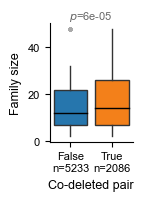

In [49]:
# Co-deleted pairs on same chr
f, ax = plt.subplots(1, 1, figsize=(1.5, 2.1))
df = pairs.assign(codel = (pairs.intersect>0))
df = df[df.same_chr]
p=stats.mannwhitneyu(df[df.codel].family_size, df[~df.codel].family_size)[1]
sns.boxplot(data=df, x='codel', y='family_size', **gp.get_boxplot_props(), ax=ax)
ax.set_xticklabels(['False\nn='+str(df[~df.codel].shape[0]), 'True\nn='+str(df[df.codel].shape[0])])
gp.set_axis_props(ax, xlabel='Co-deleted pair', xtick_fontsize=8, ylabel='Family size')
gp.draw_signif_MW(0,1,52,p,ax)
plt.tight_layout()

#### Shuffle pairs

In [50]:
# Shuffle A2s
res = []
for n in range(0,1000):
    shufpairs = pd.concat([pairs[['A1_samples','A1_chr']].reset_index(drop=True), 
                           pairs[['A2_samples','A2_chr']].sample(n=pairs.shape[0],replace=False).reset_index(drop=True)],axis=1)
    shufpairs = shufpairs[shufpairs.A1_chr!=shufpairs.A2_chr]
    shufpairs['intersect'] = shufpairs.apply(lambda x: len(set(x.A1_samples).intersection(set(x.A2_samples))), axis=1)
    res.append(shufpairs[(shufpairs.intersect>0)].shape[0]/shufpairs.shape[0])

In [51]:
pd.Series(res).to_csv(get_local_data_path(['processed','TCGA'],"shuffled_pairs_percent_codel.csv"))

In [55]:
res = pd.read_csv(get_local_data_path(['processed','TCGA'],"shuffled_pairs_percent_codel.csv"), index_col=0).iloc[:,0]

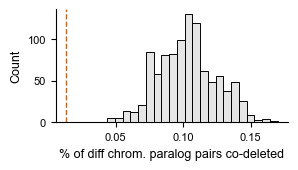

In [56]:
f, ax = plt.subplots(1, 1, figsize=(3, 1.5))
sns.histplot(res*100, ax=ax, color='#ddd'); 
ax.axvline((2/14844)*100, linestyle='--', color=gp.get_color('dark-orange'))
ax.set_xlabel('% of diff chrom. paralog pairs co-deleted');